In [1]:
import numpy as np
from abc import ABC, abstractmethod
from typing import Union

class AbstractWatermarkCode(ABC):
    @classmethod
    @abstractmethod
    def from_random(cls,
                    rng: Union[np.random.Generator, list[np.random.Generator]],
                    vocab_size: int):
        pass

class AbstractReweight(ABC):
    watermark_code_type: type[AbstractWatermarkCode]

    @abstractmethod
    def reweight(self,
                 code: AbstractWatermarkCode,
                 p: np.ndarray) -> np.ndarray:
        pass

    @abstractmethod
    def get_la_score(self,
                     code: AbstractWatermarkCode) -> np.ndarray:
        pass

def get_gumbel_variables(rng: np.random.Generator,
                         vocab_size: int):
    u = rng.random((vocab_size,))  # ~ Unifom(0, 1)
    e = -np.log(u)  # ~ Exp(1)
    g = -np.log(e)  # ~ Gumbel(0, 1)
    return u, e, g


class DeltaGumbel_WatermarkCode(AbstractWatermarkCode):
    def __init__(self, g: np.ndarray):
        self.g = g

    @classmethod
    def from_random(
            cls,
            rng: Union[np.random.Generator, list[np.random.Generator]],
            vocab_size: int,
    ):
        if isinstance(rng, list):
            batch_size = len(rng)
            g = np.stack(
                [get_gumbel_variables(rng[i], vocab_size)[2] for i in range(batch_size)]
            )
        else:
            g = get_gumbel_variables(rng, vocab_size)[2]

        return cls(g)


class DeltaGumbel_Reweight(AbstractReweight):
    watermark_code_type = DeltaGumbel_WatermarkCode

    def __repr__(self):
        return f"DeltaGumbel_Reweight()"

    def reweight(
            self, code: AbstractWatermarkCode, p_logits: np.ndarray
    ) -> np.ndarray:
        assert isinstance(code, DeltaGumbel_WatermarkCode)

        index = np.argmax(p_logits + code.g, axis=-1)

        mask = np.arange(p_logits.shape[-1]) == index[..., None]

        modified_logits = np.where(
            mask,
            np.full_like(p_logits, 0),
            np.full_like(p_logits, float("-inf")),
        )
        return modified_logits

    def get_la_score(self, code):
        """likelihood agnostic score"""
        return np.array(np.log(2)) - np.exp(-code.g)

class WatermarkDetector:
    def __init__(
            self,
            private_key: any,
            reweight: AbstractReweight,
            context_code_length: int,
            vocab_size: int = 20,
            ignore_history: bool = False
    ):
        self.private_key = private_key
        self.cc_length = context_code_length
        self.vocab_size = vocab_size
        self.reweight = reweight
        self.ignore_history = ignore_history
        self.cc_history = set()

    def reset_history(self):
        self.cc_history = set()

    def get_rng_seed(self, context_code: any) -> any:
        if not self.ignore_history:
            self.cc_history.add(context_code)
        import hashlib

        m = hashlib.sha256()
        m.update(context_code)
        m.update(self.private_key)
        full_hash = m.digest()
        seed = int.from_bytes(full_hash, "big") % (2 ** 32 - 1)
        return seed

    def _get_codes(self, context):
        batch_size = len(context)

        context_codes = [
            context[i][-self.cc_length:].tobytes() for i in range(batch_size)
        ]
        # print(context[0][-self.cc_length:])
        mask, seeds = zip(
            *[
                (context_code in self.cc_history, self.get_rng_seed(context_code))
                for context_code in context_codes
            ]
        )
        return mask, seeds

    def detect(self,
               input_ids: np.ndarray,
               method='original'):
        """
        :param input_ids: sequences after tokenization
        :return: scores, a higher score means a seq is likely to be watermarked
        """
        if method == 'optimized':
            scores = []
            for i in range(input_ids.shape[1]):
                score = self.get_la_score(input_ids[:, :i], input_ids[:, i], self.vocab_size)
                ti = score-np.log(2)
                scores.append(ti)
            assert np.all(ti<=0), ti
            tis = np.array(scores)
            uis = np.exp(tis)
            Ubar=np.mean(uis)
            # print("Ubar", Ubar)

            if np.mean(uis)==0:
                final_score=0
                final_p_value=1
                return final_score, final_p_value
            avgS = lambda Ubar, lamb: Ubar*lamb+np.log(lamb/np.expm1(lamb))
            import scipy.optimize
            sol=scipy.optimize.minimize(lambda l:-avgS(Ubar, l), 0.5, bounds=[(0,10)])
            final_score=-sol.fun*input_ids.shape[1]
            final_p_value = np.exp(-final_score)
            return final_score, final_p_value
        
        elif method == 'original':
            scores = []
            for i in range(input_ids.shape[1]):
                score = self.get_la_score(input_ids[:, :i], input_ids[:, i], self.vocab_size)
                scores.append(score)
            scores = np.array(scores)
            final_score = np.sum(scores, axis=0)
            return final_score, np.exp(-final_score)

    def get_la_score(
            self,
            input_ids: np.ndarray,
            labels: np.ndarray,
            vocab_size: int,
    ) -> np.ndarray:
        assert "get_la_score" in dir(
            self.reweight
        ), "Reweight does not support likelihood agnostic detection"
        mask, seeds = self._get_codes(input_ids)
        rng = [
            np.random.default_rng(seed) for seed in seeds
        ]
        
        mask = np.array(mask)
        watermark_code = self.reweight.watermark_code_type.from_random(rng, vocab_size)
        all_scores = self.reweight.get_la_score(watermark_code)
        scores = all_scores[np.arange(all_scores.shape[0]), labels]
        
        scores = np.logical_not(mask) * scores
        return scores

In [2]:
amino_acids = 'ACDEFGHIKLMNPQRSTVWYX'  # List of amino acids
# Create a dictionary mapping each amino acid to its index
aa_to_index = {aa: idx for idx, aa in enumerate(amino_acids)}
class AminoAcidTokenizer:
    def __init__(self, aa_to_index):
        self.aa_to_index = aa_to_index
        self.index_to_aa = {idx: aa for aa, idx in aa_to_index.items()}
        
    def encode(self, sequence):
        # Encode a sequence of amino acids to indices
        return np.array([self.aa_to_index.get(aa, self.aa_to_index.get('X')) for aa in sequence]).reshape(1,-1)
        
    def decode(self, indices):
        # Decode a list of indices back into an amino acid sequence
        return ''.join(self.index_to_aa.get(idx, 'X') for idx in indices)
tokenizer = AminoAcidTokenizer(aa_to_index)

In [3]:
import os
import re
import pandas as pd
data = []

for t in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    directory = './entropy/monomer_design_entropy/'+ str(t)+'/seqs/'
    for filename in os.listdir(directory):
        if filename.endswith('.fa'):
            file_path = os.path.join(directory, filename)
            with open(file_path, 'r') as file:
                lines = file.readlines()
            # Process the designed sequences
            info = re.search(r'^>([^,]+),.*sample=(\d+),.*score=([^,]+),.*seq_recovery=([^,]+)', lines[2])
        
            seq = lines[3].strip()
            
            detector = WatermarkDetector(b"private key",
                                         DeltaGumbel_Reweight(),
                                         context_code_length=5,
                                         vocab_size=21)
            original_score = ((detector.detect(tokenizer.encode(seq), method='original')[0])/len(seq))[0]
            
            detector = WatermarkDetector(b"private key",
                                         DeltaGumbel_Reweight(),
                                         context_code_length=5,
                                         vocab_size=21)
            optimized_score = ((detector.detect(tokenizer.encode(seq), method='optimized')[0])/len(seq))[0]
            
            # attack the seq
            seq_a2g = seq.replace('A', 'G')
            detector = WatermarkDetector(b"private key",
                                         DeltaGumbel_Reweight(),
                                         context_code_length=5,
                                         vocab_size=21)
            a2g_score = ((detector.detect(tokenizer.encode(seq_a2g), method='optimized')[0])/len(seq))[0]
            
            # attack the seq
            seq_g2a = seq.replace('G', 'A')
            detector = WatermarkDetector(b"private key",
                                         DeltaGumbel_Reweight(),
                                         context_code_length=5,
                                         vocab_size=21)
            g2a_score = ((detector.detect(tokenizer.encode(seq_g2a), method='optimized')[0])/len(seq))[0]
            
            # wrong key
            detector = WatermarkDetector(b"privat key",
                                         DeltaGumbel_Reweight(),
                                         context_code_length=5,
                                         vocab_size=21)
            wk_score = ((detector.detect(tokenizer.encode(seq), method='optimized')[0])/len(seq))[0]
            
            data.append({'sample': filename[:-3],
                         'T': float(info.group(1)[2:]),
                         'original_score': float(original_score),
                         'optimized_score': float(optimized_score),
                         'g2a_score': float(g2a_score),
                         'a2g_score': float(a2g_score),
                         'wrong key': float(wk_score),
                        })   

/var/folders/js/g7pncpj135j12v52t38tgclh0000gn/T/ipykernel_78882/1179788289.py:151: RuntimeWarning: invalid value encountered in true_divide
  avgS = lambda Ubar, lamb: Ubar*lamb+np.log(lamb/np.expm1(lamb))


In [4]:
df_1 = pd.DataFrame(data)

In [5]:
import json
ordered_name = []
with open('./entropy/monomer_design_entropy/parsed_pdbs.jsonl', 'r') as file:
    # Iterate over each line in the file
    for line in file:
        # Parse the line as JSON
        json_object = json.loads(line)
        # Access and print the "name" value
        ordered_name.append(json_object['name'])

ordered_name = ordered_name*10

text_file_path = './entropy/entropy_temperature.txt'

# Initialize lists to hold the extracted data
names = []
temperatures = []
entropies = []

# Read the text file and extract data
with open(text_file_path, 'r') as file:
    lines = file.readlines()

# Assuming each sample name corresponds to every 10 lines in the text file
for i, line in enumerate(lines):
    parts = line.split()
    temperature = float(parts[1])
    entropy = float(parts[4])
    
    # Find the corresponding sample name (each name repeats every 10 lines)
    sample_name = ordered_name[i]
    
    names.append(sample_name)
    temperatures.append(temperature)
    entropies.append(entropy)

# Convert lists to a DataFrame
data = {'sample': names, 'T': temperatures, 'entropy': entropies}
df_2 = pd.DataFrame(data)

In [6]:
df = pd.merge(df_1, df_2, on=['sample', 'T'])

In [7]:
df.to_csv('./entropy_results.csv')

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

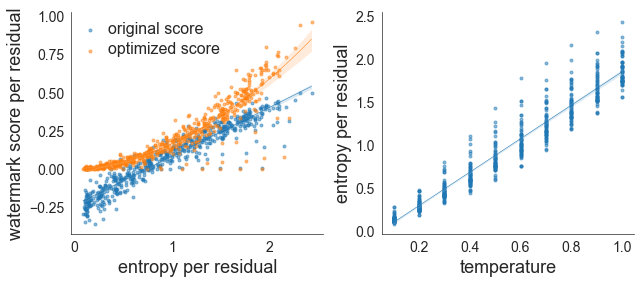

In [11]:
sns.set_style("white")
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

sns.regplot(data=df, x='entropy', y='original_score', order=1, ax=axes[0],
            label='original score', marker='.', scatter_kws={'alpha':0.5},
            line_kws={'linewidth': 0.5})
sns.regplot(data=df, x='entropy', y='optimized_score', order=2, ax=axes[0], 
            label='optimized score',marker='.', scatter_kws={'alpha':0.5},
            line_kws={'linewidth': 0.5})

axes[0].set_xlabel('entropy per residual', fontsize=18)
axes[0].set_ylabel('watermark score per residual', fontsize=18)
axes[0].tick_params(axis='both', which='major', labelsize=14) 
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['left'].set_linewidth(0.7)
axes[0].spines['bottom'].set_linewidth(0.7)
axes[0].legend(title='detection method')
legend = axes[0].legend(frameon=False)  # Remove legend border
plt.setp(legend.get_texts(), fontsize=16)

sns.regplot(data=df, x='T', y='entropy', ax=axes[1],
            marker='.', scatter_kws={'alpha':0.5},
            line_kws={'linewidth': 0.5})
axes[1].set_ylabel('entropy per residual', fontsize=18)
axes[1].set_xlabel('temperature', fontsize=18)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['left'].set_linewidth(0.7)
axes[1].spines['bottom'].set_linewidth(0.7)
axes[1].tick_params(axis='both', which='major', labelsize=14) 
plt.tight_layout()
plt.savefig("mpnn_score&entropy&temp.pdf", format='pdf')

plt.show()


<AxesSubplot:xlabel='T', ylabel='entropy'>

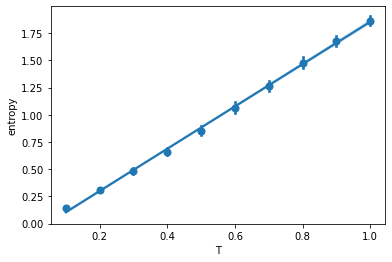

In [14]:
sns.regplot(data=df, x='T', y='entropy',x_estimator=np.mean)

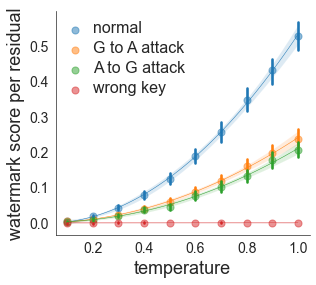

In [21]:
import matplotlib
fig, ax = plt.subplots(1, 1, figsize=(4.5, 4))
sns.regplot(data=df, x='T', y='optimized_score',
            x_estimator=np.mean, order=2, ax=ax,
            label='normal', line_kws={'linewidth': 0.5},
            scatter_kws={'alpha':0.5})

sns.regplot(data=df, x='T', y='g2a_score',
            x_estimator=np.mean, order=2, ax=ax,
            label="G to A attack", line_kws={'linewidth': 0.5},
            scatter_kws={'alpha':0.5})

sns.regplot(data=df, x='T', y='a2g_score',
            x_estimator=np.mean, order=2, ax=ax,
            label="A to G attack",line_kws={'linewidth': 0.5},
            scatter_kws={'alpha':0.5})

sns.regplot(data=df, x='T', y='wrong key',
            x_estimator=np.mean, order=1, ax=ax,
            label="wrong key",line_kws={'linewidth': 0.5},
            scatter_kws={'alpha':0.5})
ax.set_xlabel('temperature', fontsize=18)
ax.set_ylabel('watermark score per residual', fontsize=18)
legend = ax.legend(frameon=False)  # Remove legend border
plt.setp(legend.get_texts(), fontsize=16)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.7)
ax.spines['bottom'].set_linewidth(0.7)

for child in ax.get_children():
    if isinstance(child, matplotlib.collections.LineCollection):
        # Set the error bar line width here
        child.set_linewidth(0.5)  # Adjust this value as needed


ax.tick_params(axis='both', which='major', labelsize=14) 

plt.tight_layout()
plt.savefig("watermark_robustness.pdf", format='pdf')
plt.show()